In [1]:
# Libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for ML
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imb_pipeline
import shap
import joblib

# Keras for neural networks
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras import regularizers
from keras.utils import to_categorical

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
# Load dataset
df = pd.read_csv("./heart-disease-diagnosis-dataset/dataset_heart.csv")

# Map target variable to binary (1: heart disease, 0: no disease)
df['heart disease'] = df['heart disease'].map({1: 0, 2: 1})

# Feature engineering (from test.pdf)
df['age_chol'] = df['age'] * df['serum cholestoral']
df['bp_hr_ratio'] = df['resting blood pressure'] / df['max heart rate']

# Split data
X = df.drop('heart disease', axis=1)
y = df['heart disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

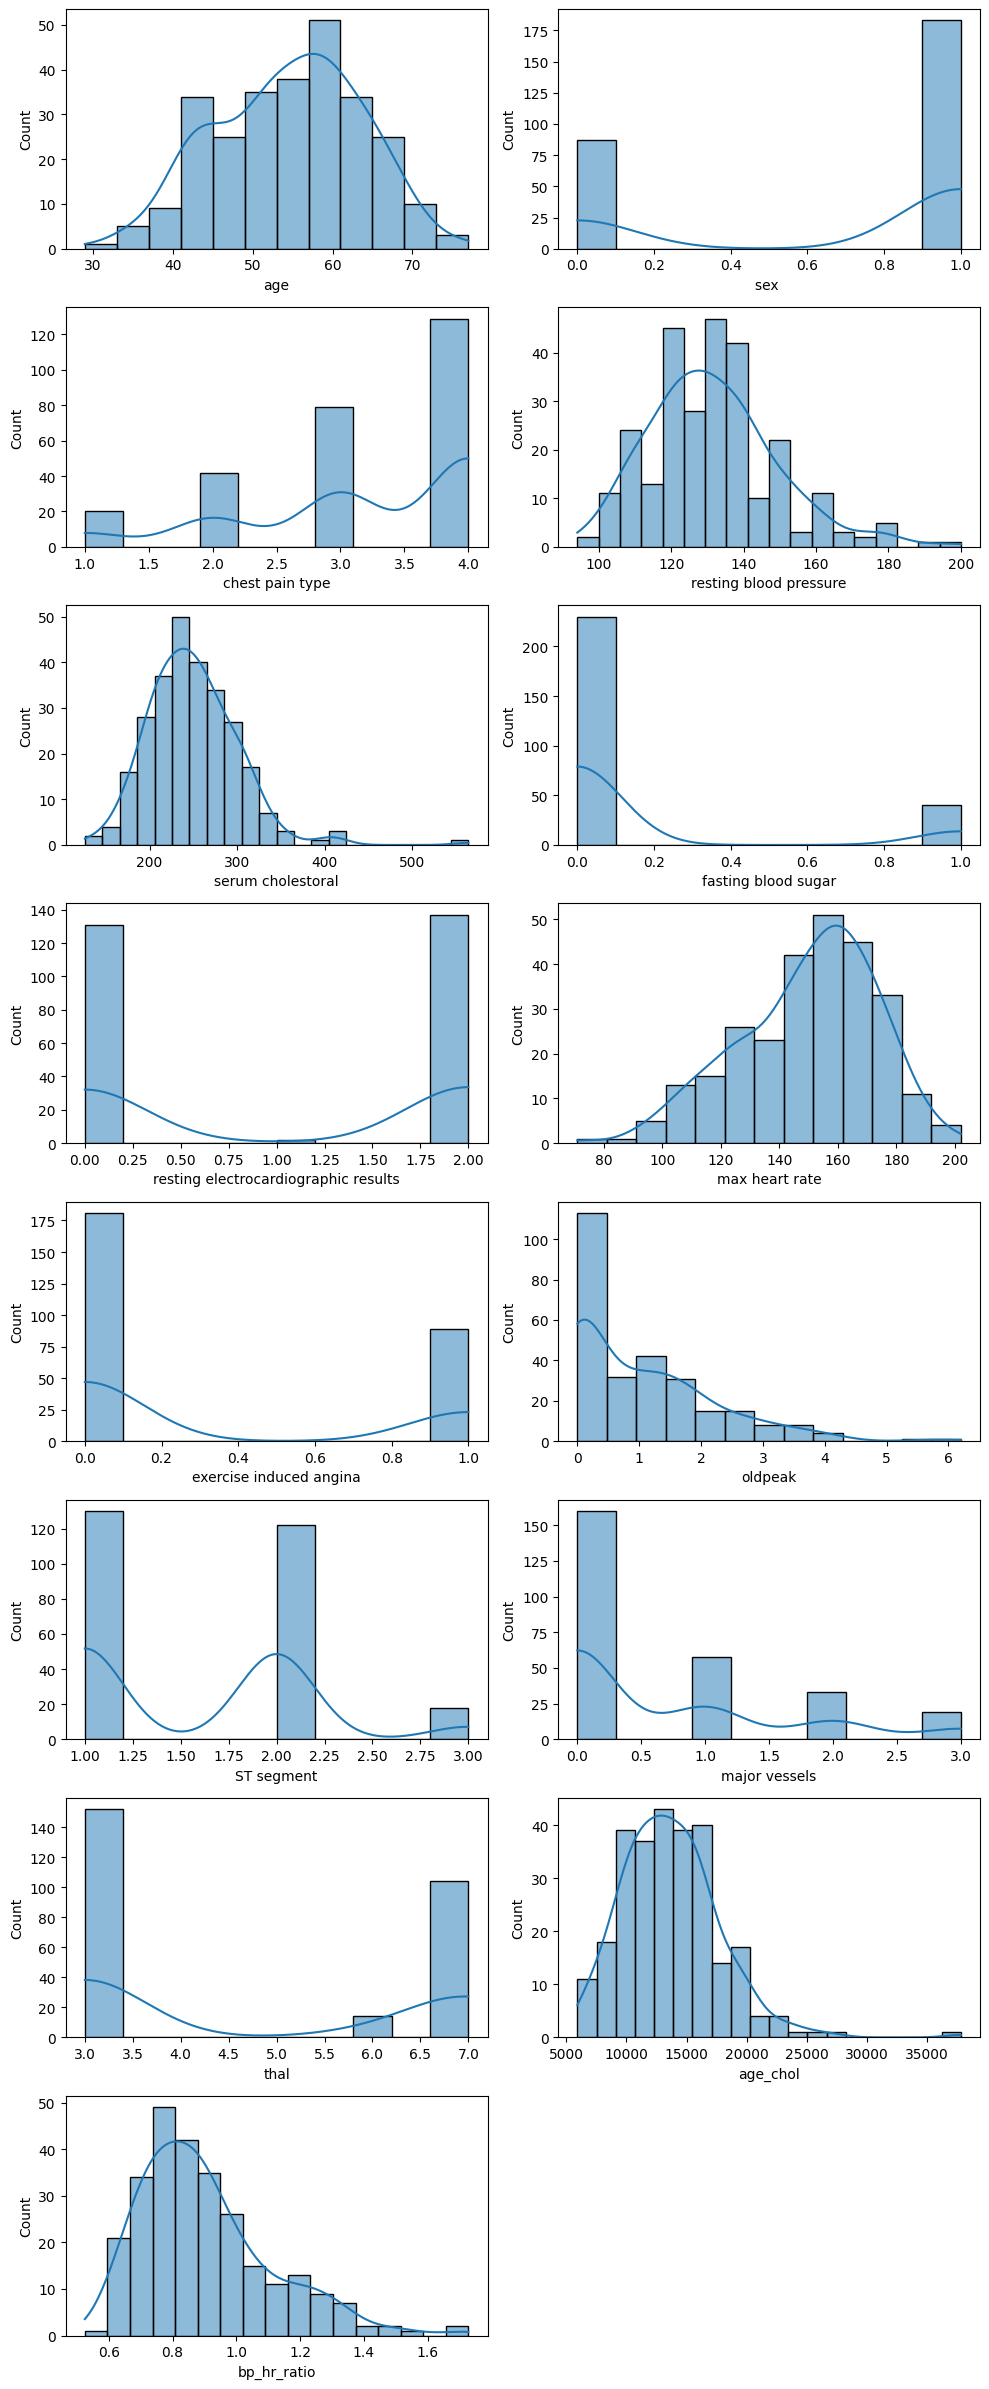

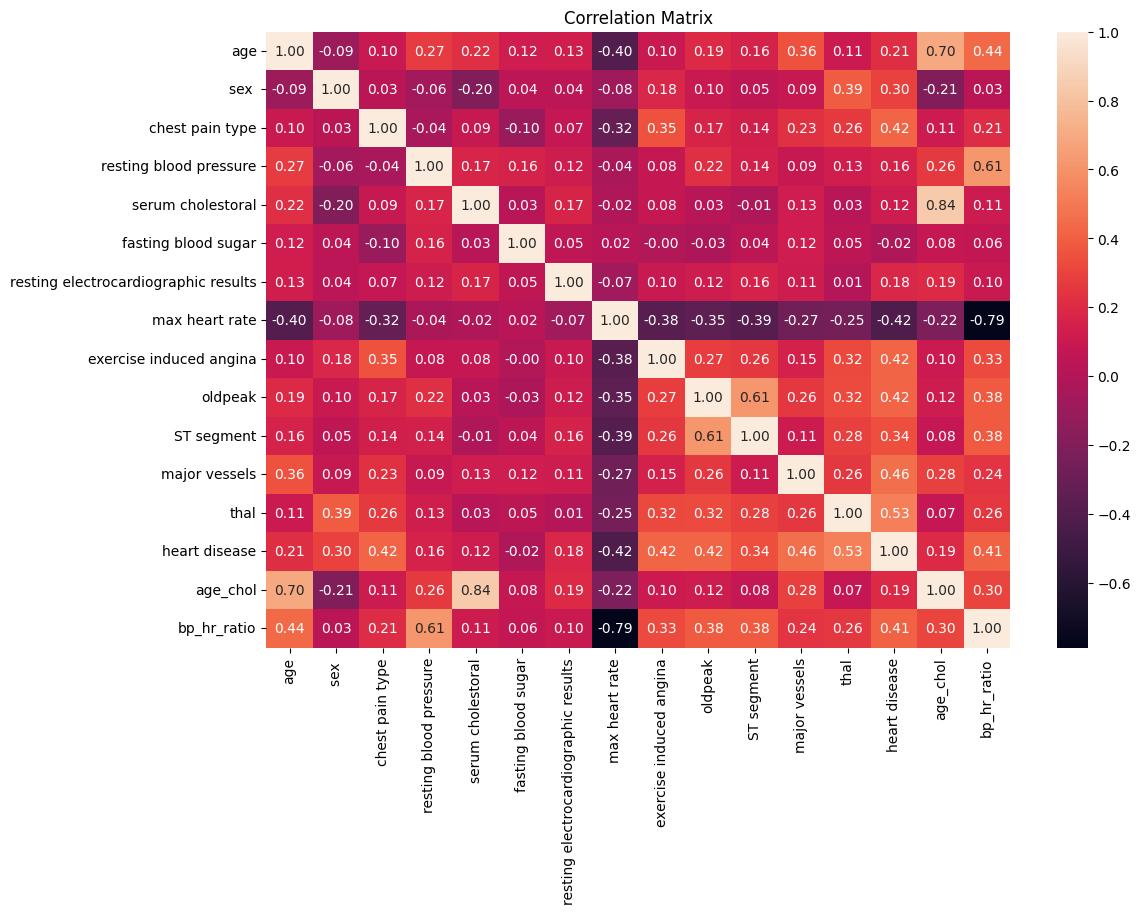

In [4]:
# Histograms and boxplots for all features (from test.pdf)
num_rows = (len(X.columns) + 1) // 2
plt.figure(figsize=(10, num_rows * 3))
for i, column in enumerate(X.columns, 1):
    plt.subplot(num_rows, 2, i)
    sns.histplot(X[column], kde=True)
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [5]:
# Define pipeline with SMOTE and scaling
pipeline = imb_pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier())
])

# Hyperparameter tuning
params = {
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__n_estimators': [100, 200]
}

grid_search = GridSearchCV(pipeline, params, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.77      0.83      0.80        24

    accuracy                           0.81        54
   macro avg       0.81      0.82      0.81        54
weighted avg       0.82      0.81      0.82        54



In [6]:
# Preprocess data for Keras
X_nn = StandardScaler().fit_transform(X)
y_nn = to_categorical(y, num_classes=2)  # Binary classification

# Split data
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2, stratify=y_nn, random_state=42)

# Define Keras model
def create_nn_model():
    model = Sequential()
    model.add(Dense(16, input_dim=X.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.25))
    model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.25))
    model.add(Dense(2, activation='softmax'))  # 2 output neurons for binary classification
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Train model
nn_model = create_nn_model()
history = nn_model.fit(X_train_nn, y_train_nn, validation_data=(X_test_nn, y_test_nn), epochs=50, batch_size=10)

Epoch 1/50
22/22 [==============================] - 0s 5ms/step - loss: 1.0754 - accuracy: 0.4444 - val_loss: 0.8281 - val_accuracy: 0.5185
Epoch 2/50
22/22 [==============================] - 0s 1ms/step - loss: 0.8212 - accuracy: 0.5231 - val_loss: 0.7347 - val_accuracy: 0.6667
Epoch 3/50
22/22 [==============================] - 0s 1ms/step - loss: 0.8727 - accuracy: 0.4861 - val_loss: 0.6670 - val_accuracy: 0.7407
Epoch 4/50
22/22 [==============================] - 0s 1ms/step - loss: 0.7738 - accuracy: 0.5787 - val_loss: 0.6236 - val_accuracy: 0.7222
Epoch 5/50
22/22 [==============================] - 0s 1ms/step - loss: 0.6630 - accuracy: 0.6019 - val_loss: 0.5986 - val_accuracy: 0.6852
Epoch 6/50
22/22 [==============================] - 0s 1ms/step - loss: 0.6494 - accuracy: 0.6898 - val_loss: 0.5706 - val_accuracy: 0.6852
Epoch 7/50
22/22 [==============================] - 0s 1ms/step - loss: 0.5916 - accuracy: 0.7222 - val_loss: 0.5627 - val_accuracy: 0.6852
Epoch 8/50
22/22 [==

In [7]:
# Compare XGBoost and Neural Network
print("XGBoost Results:")
print(classification_report(y_test, y_pred))

print("\nNeural Network Results:")
nn_pred = np.argmax(nn_model.predict(X_test_nn), axis=1)
print(classification_report(np.argmax(y_test_nn, axis=1), nn_pred))

XGBoost Results:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.77      0.83      0.80        24

    accuracy                           0.81        54
   macro avg       0.81      0.82      0.81        54
weighted avg       0.82      0.81      0.82        54


Neural Network Results:
2/2 [==============================] - 0s 997us/step
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        30
           1       0.75      0.75      0.75        24

    accuracy                           0.78        54
   macro avg       0.78      0.78      0.78        54
weighted avg       0.78      0.78      0.78        54

